In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC

df = pd.read_csv("Groundwater all_years.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (37410, 8)
     pH  EC (µS/cm)   HCO3  Cl (mg/L)  SO4  Total Hardness  Na (mg/L)   F
0  8.09       385.0  268.4       24.8  NaN           160.0       20.8 NaN
1  7.82        40.5   18.3        3.5  NaN            20.0        0.4 NaN
2  8.32       324.5  207.4       35.5  NaN           150.0       22.0 NaN
3  8.47        59.9   67.1       28.4  NaN            80.0        4.2 NaN
4  7.78       841.4  317.2       85.1  NaN           210.0       90.1 NaN


In [ ]:
df = df.apply(pd.to_numeric, errors='coerce')

In [27]:
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
pH                   0
EC (µS/cm)           0
HCO3              1552
Cl (mg/L)         1520
SO4               4049
Total Hardness    1517
Na (mg/L)         1548
F                 3085
dtype: int64


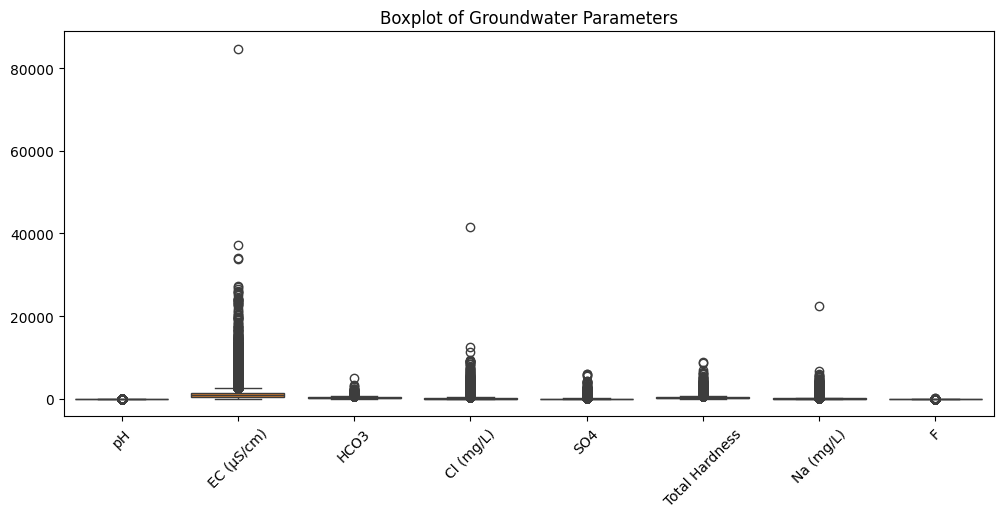

In [28]:
plt.figure(figsize=(12,5))
sns.boxplot(data=df)
plt.title("Boxplot of Groundwater Parameters")
plt.xticks(rotation=45)
plt.show()

In [32]:
df = df.fillna(df.median())

print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
pH                0
EC (µS/cm)        0
HCO3              0
Cl (mg/L)         0
SO4               0
Total Hardness    0
Na (mg/L)         0
F                 0
dtype: int64


In [33]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df.clip(lower=lower_bound, upper=upper_bound, axis=1)

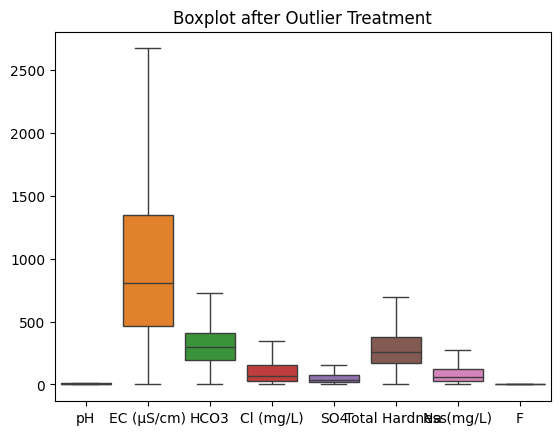

In [38]:
sns.boxplot(data=df)
plt.title("Boxplot after Outlier Treatment")
plt.show()


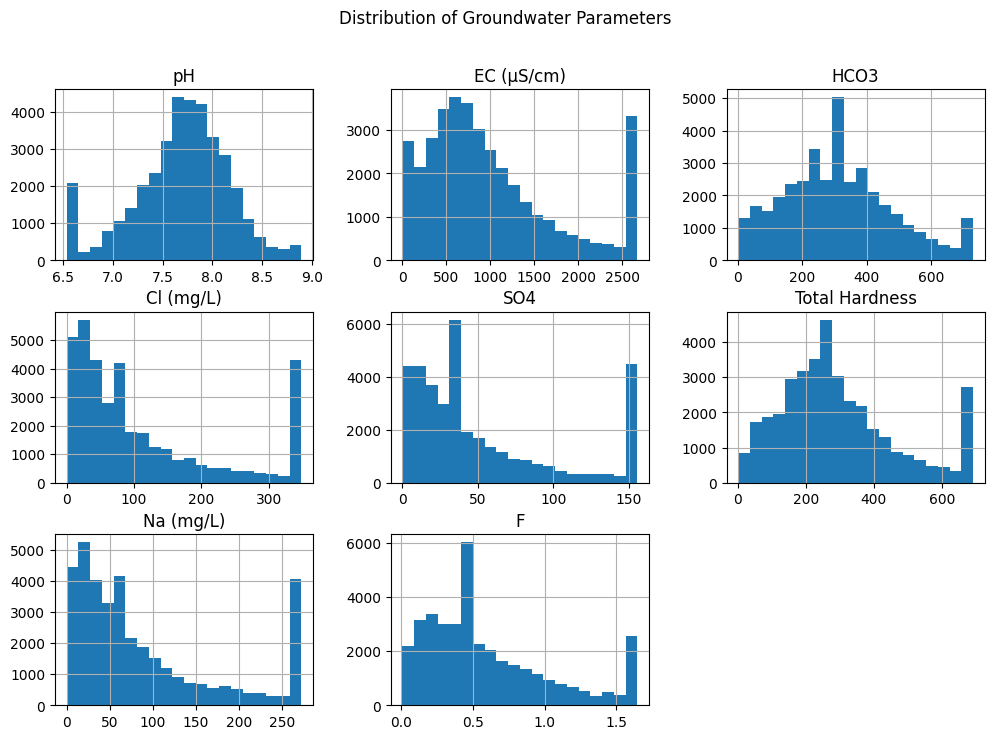

In [39]:
df.hist(figsize=(12,8), bins=20)
plt.suptitle("Distribution of Groundwater Parameters")
plt.show()

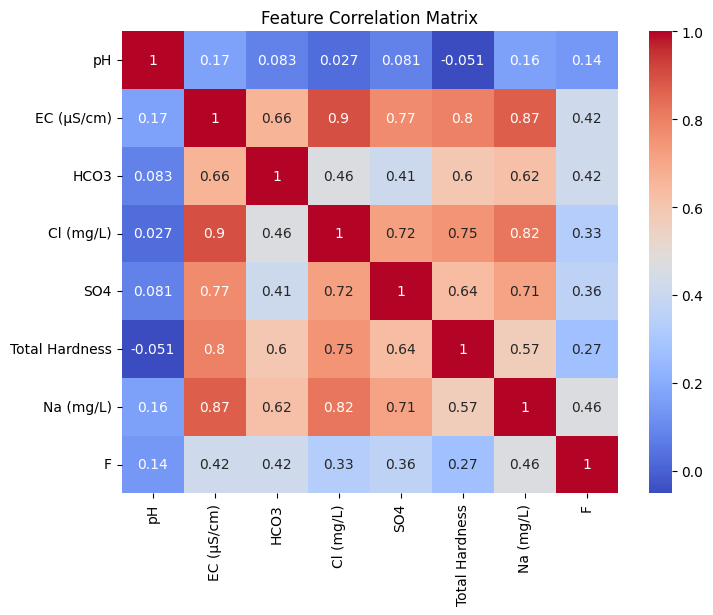

In [40]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [41]:
df['Water_Quality_Label'] = (
    (df['pH'].between(6.5, 8.5)) &
    (df['EC (µS/cm)'] <= 1500) &
    (df['Total Hardness'] <= 300) &
    (df['F'] <= 1.5) &
    (df['Cl (mg/L)'] <= 250) &
    (df['SO4'] <= 200)
).astype(int)

print(df['Water_Quality_Label'].value_counts())


Water_Quality_Label
1    20206
0    17204
Name: count, dtype: int64


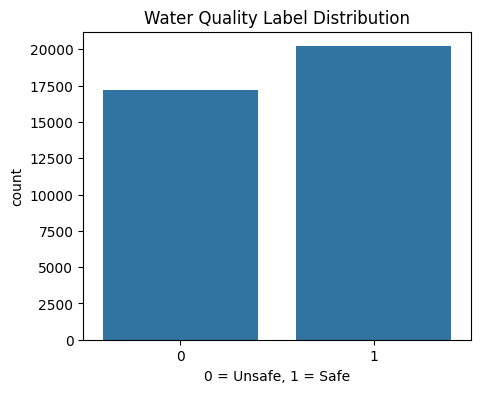

In [42]:
plt.figure(figsize=(5,4))
sns.countplot(x=df['Water_Quality_Label'])
plt.title("Water Quality Label Distribution")
plt.xlabel("0 = Unsafe, 1 = Safe")
plt.show()


In [44]:
X = df.drop('Water_Quality_Label', axis=1)
y = df['Water_Quality_Label']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)


In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [46]:
lr = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', probability=True)

lr.fit(X_train, y_train)
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)


SVC(probability=True)

In [47]:
stack_model = StackingClassifier(
    estimators=[
        ('knn', knn),
        ('dt', dt),
        ('svm', svm)
    ],
    final_estimator=LogisticRegression()
)

stack_model.fit(X_train, y_train)


StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier(random_state=42)),
                               ('svm', SVC(probability=True))],
                   final_estimator=LogisticRegression())

In [48]:
models = {
    "Logistic Regression": lr,
    "KNN": knn,
    "Decision Tree": dt,
    "Random Forest": rf,
    "SVM": svm,
    "Stacking Classifier": stack_model
}

for name, model in models.items():
    pred = model.predict(X_test)
    print(f"{name} Accuracy:", accuracy_score(y_test, pred))


Logistic Regression Accuracy: 0.9136594493450949
KNN Accuracy: 0.9665864742047581
Decision Tree Accuracy: 1.0
Random Forest Accuracy: 0.999866345896819
SVM Accuracy: 0.9852980486500935
Stacking Classifier Accuracy: 1.0


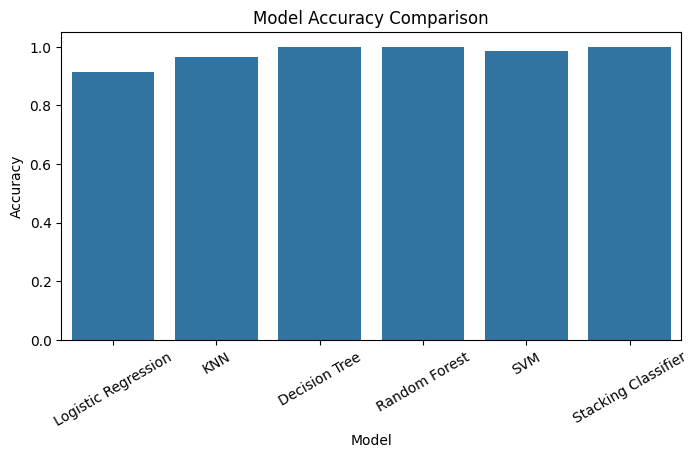

In [49]:
accuracy_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": [accuracy_score(y_test, m.predict(X_test)) for m in models.values()]
})

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=accuracy_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=30)
plt.show()


In [52]:
print("\nEnter groundwater values:")

ph = float(input("pH: "))
ec = float(input("EC (µS/cm): "))
hco3 = float(input("HCO3: "))
cl = float(input("Cl (mg/L): "))
so4 = float(input("SO4: "))
hardness = float(input("Total Hardness: "))
na = float(input("Na (mg/L): "))
f = float(input("F: "))

# Create DataFrame with SAME columns used during training
user_df = pd.DataFrame(
    [[ph, ec, hco3, cl, so4, hardness, na, f]],
    columns=[
        'pH',
        'EC (µS/cm)',
        'HCO3',
        'Cl (mg/L)',
        'SO4',
        'Total Hardness',
        'Na (mg/L)',
        'F'
    ]
)

# Scale using already-fitted scaler
user_df_scaled = scaler.transform(user_df)

# Predict using trained stacking model
prediction = stack_model.predict(user_df_scaled)

# Display result
if prediction[0] == 1:
    print("Predicted Water Quality: SAFE")
else:
    print("Predicted Water Quality: UNSAFE")



Enter groundwater values:


pH:  7
EC (µS/cm):  800
HCO3:  700
Cl (mg/L):  450
SO4:  500
Total Hardness:  650
Na (mg/L):  700
F:  1


Predicted Water Quality: UNSAFE
